In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dask.distributed import Client, LocalCluster
client = Client(n_workers=1,
                threads_per_worker=4,
                memory_limit='20GB')
client

/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45071 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45071/status,
Dashboard: http://127.0.0.1:45071/status,Workers: 1
Total threads: 4,Total memory: 18.63 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37845,Workers: 1
Dashboard: http://127.0.0.1:45071/status,Total threads: 4
Started: Just now,Total memory: 18.63 GiB
Comm: tcp://127.0.0.1:45707,Total threads: 4
Dashboard: http://127.0.0.1:36577/status,Memory: 18.63 GiB
Nanny: tcp://127.0.0.1:43741,


In [3]:
import copy
import sys
import xarray as xr
import numpy as np
import dask.array as da
import time
import os

import dask

import matplotlib.pyplot as plt
import hvplot.xarray
import holoviews as hv
import scipy.constants

sys.path.append("..")
import processing_dask as pr
import plot_dask
import processing as old_processing

sys.path.append("../../preprocessing/")
from generate_chirp import generate_chirp

In [4]:
# TEST FILES
#prefix = "/home/thomas/Documents/StanfordGrad/RadioGlaciology/drone/radar_data/20230621-bench-prf-testing/20230621_163428"

# 6-21 Tests with SN 02
#prefix = "/home/thomas/Documents/StanfordGrad/RadioGlaciology/drone/radar_data/20230621-bench-prf/20230622_104230" # pulse_rep_int .012 -- run fully
prefix = "/home/thomas/Documents/StanfordGrad/RadioGlaciology/drone/radar_data/20230621-bench-prf/20230622_101719" # pulse_rep_int .009
#prefix = "/home/thomas/Documents/StanfordGrad/RadioGlaciology/drone/radar_data/20230621-bench-prf/20230621_181056" # pulse_rep_int .006 -- run fully
#prefix = "/home/thomas/Documents/StanfordGrad/RadioGlaciology/drone/radar_data/20230621-bench-prf/20230621_173826" # pulse_rep_int .003 -- run fully

zero_sample_idx = 159
sig_speed = scipy.constants.speed_of_light * (2/3)

zarr_path = pr.save_radar_data_to_zarr(prefix, zarr_base_location="/home/thomas/Documents/StanfordGrad/RadioGlaciology/test_tmp_zarr_cache/", skip_if_cached=True)

zarr_path

'/home/thomas/Documents/StanfordGrad/RadioGlaciology/test_tmp_zarr_cache/20230622_101719.zarr'

In [5]:
raw = xr.open_zarr(zarr_path)
raw = pr.remove_errors(raw)

In [6]:
config_blackman_window = copy.deepcopy(raw.config)
config_blackman_window['GENERATE']['window'] = 'blackman'

chirp_ts, chirp = generate_chirp(config_blackman_window)
compressed = pr.pulse_compress(raw, chirp,
                               fs=raw.config['GENERATE']['sample_rate'],
                               zero_sample_idx=zero_sample_idx,
                               signal_speed=scipy.constants.c * (2/3)).persist()

In [7]:
ts = np.logspace(np.log10(2e-2), np.log10(300), 20)

## Noise Floor Variance

In [8]:
actual_stack_t = np.nan * np.zeros_like(ts)
actual_stack_n = np.zeros_like(ts, dtype=int)
stack_noise_var = np.nan * np.zeros_like(ts)

In [9]:
for t_idx, t in enumerate(ts):
    if not np.isnan(stack_noise_var[t_idx]):
        continue
    
    timestamp = time.time()
    actual_stack_n[t_idx] = int(t / raw.attrs['config']['CHIRP']['pulse_rep_int'])
    actual_stack_t[t_idx] = actual_stack_n[t_idx] * raw.attrs['config']['CHIRP']['pulse_rep_int']
    print(f"[{t_idx+1}/{len(ts)}] \tt={actual_stack_t[t_idx]} \tn_stack={actual_stack_n[t_idx]}")
    
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        stacked = pr.stack(compressed, actual_stack_n[t_idx])
        compressed_mag = xr.apply_ufunc(np.abs, stacked, dask='parallelized')
        vs = compressed_mag["radar_data"].where((compressed_mag.reflection_distance > 2000) & (compressed_mag.reflection_distance < 4000)).dropna('travel_time').var(dim="travel_time")
        if len(vs) > 10:
            vs = vs[:10]
        stack_noise_var[t_idx] = vs.mean().compute().item()
    print(f"Completed in {time.time() - timestamp} seconds from {len(vs)} computed variances")

[1/20] 	t=0.018 	n_stack=2


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 67.00492739677429 seconds from 10 computed variances
[2/20] 	t=0.026999999999999996 	n_stack=3


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 14.99501895904541 seconds from 10 computed variances
[3/20] 	t=0.05399999999999999 	n_stack=6


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 19.63747525215149 seconds from 10 computed variances
[4/20] 	t=0.09 	n_stack=10


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 21.05410861968994 seconds from 10 computed variances
[5/20] 	t=0.144 	n_stack=16


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 19.617106199264526 seconds from 10 computed variances
[6/20] 	t=0.243 	n_stack=27


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 20.362467527389526 seconds from 10 computed variances
[7/20] 	t=0.414 	n_stack=46


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 22.038259744644165 seconds from 10 computed variances
[8/20] 	t=0.6839999999999999 	n_stack=76


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 22.255882024765015 seconds from 10 computed variances
[9/20] 	t=1.143 	n_stack=127


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 16.51035714149475 seconds from 10 computed variances
[10/20] 	t=1.8989999999999998 	n_stack=211


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 9.149649620056152 seconds from 10 computed variances
[11/20] 	t=3.15 	n_stack=350


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 6.303068161010742 seconds from 10 computed variances
[12/20] 	t=5.228999999999999 	n_stack=581


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 5.32344651222229 seconds from 10 computed variances
[13/20] 	t=8.676 	n_stack=964


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 4.2719666957855225 seconds from 10 computed variances
[14/20] 	t=14.390999999999998 	n_stack=1599


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 4.399463891983032 seconds from 10 computed variances
[15/20] 	t=23.886 	n_stack=2654


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 4.574132680892944 seconds from 10 computed variances
[16/20] 	t=39.617999999999995 	n_stack=4402


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


Completed in 5.621078252792358 seconds from 10 computed variances
[17/20] 	t=65.71799999999999 	n_stack=7302


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)
2023-06-29 09:45:44,672 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Completed in 7.511889934539795 seconds from 9 computed variances
[18/20] 	t=109.026 	n_stack=12114


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)
2023-06-29 09:46:03,441 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Completed in 16.859901189804077 seconds from 5 computed variances
[19/20] 	t=180.84599999999998 	n_stack=20094


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)
2023-06-29 09:46:17,569 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Completed in 29.614583015441895 seconds from 3 computed variances
[20/20] 	t=299.99699999999996 	n_stack=33333


/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)
2023-06-29 09:46:36,083 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-06-29 09:46:39,224 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Completed in 6.919309139251709 seconds from 1 computed variances


In [10]:
output_base_stack = os.path.join("20230628-outputs/", raw.attrs["basename"]+"-stack")

d = xr.Dataset({"noise_var": ("t", stack_noise_var)}, coords={"t": actual_stack_t, "n_stack": ("t", actual_stack_n)})
d.to_netcdf(output_base_stack + ".nc")

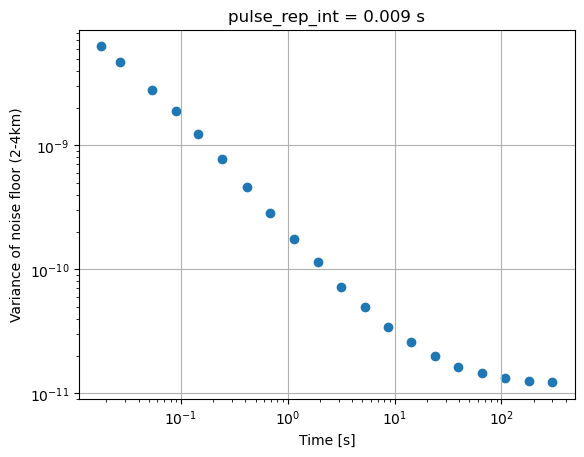

In [11]:
fig, ax = plt.subplots()
ax.loglog()
ax.scatter(actual_stack_t, stack_noise_var)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Variance of noise floor (2-4km)')
ax.set_title(f"pulse_rep_int = {raw.attrs['config']['CHIRP']['pulse_rep_int']} s")
plt.grid()
fig.savefig(output_base_stack + ".png")

## Signal peak phase

In [12]:
# Signal
reflector_distance_expected = 25
expected_peak_idx = (np.abs(compressed.reflection_distance - reflector_distance_expected)).argmin().item()

peak_idxs = compressed["radar_data"].reduce(
    lambda x, axis: (np.abs((x[:, expected_peak_idx-5:expected_peak_idx+5]))).argmax(axis=axis) + expected_peak_idx-5,
    dim='travel_time')
peak_idxs.persist()
true_peak_idx = peak_idxs[0].compute().item()
if not (peak_idxs == true_peak_idx).all().compute().item():
    print("WARNING: Peak indices are not all the same!")

2023-06-29 09:46:43,684 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-06-29 09:46:45,485 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-06-29 09:46:47,418 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [13]:
peak_phases = xr.apply_ufunc(
        lambda x, idx: np.angle(x[idx]),
        compressed["radar_data"], peak_idxs,
        input_core_dims=[['travel_time'],[]], # The dimension operated over -- aka "don't vectorize over this"
        output_core_dims=[[]], # The output dimensions of the lambda function itself
        exclude_dims=set(("travel_time",)), # Dimensions to not vectorize over
        vectorize=True, # Vectorize other dimensions using a call to np.vectorize
        dask="parallelized", # Allow dask to chunk and parallelize the computation
        output_dtypes=[np.float32], # Needed for dask: explicitly provide the output dtype
        #dask_gufunc_kwargs={"output_sizes": {'travel_time': 1}} # Also needed for dask:
        # explicitly provide the output size of the lambda function. See
        # https://docs.dask.org/en/stable/generated/dask.array.gufunc.apply_gufunc.html
    ).persist()

/home/thomas/apps/miniconda3/envs/rg2/lib/python3.11/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


In [14]:
fs = raw.attrs['config']['GENERATE']['sample_rate']

actual_dt = np.zeros_like(ts)
var = np.zeros_like(ts)

for t_idx, t in enumerate(ts):
    print(f"[{t_idx}/{len(ts)}] \tt={t}")
    pulses = int(t / raw.attrs['config']['CHIRP']['pulse_rep_int'])
    actual_dt[t_idx] = pulses * raw.attrs['config']['CHIRP']['pulse_rep_int']
    ph_group_mean = peak_phases.rolling(pulse_idx=pulses).mean()
    var[t_idx] = ((ph_group_mean[:-pulses].drop_indexes("pulse_idx") - ph_group_mean[pulses:].drop_indexes("pulse_idx"))**2).mean().compute().item()

[0/20] 	t=0.02


2023-06-29 09:47:27,910 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-06-29 09:47:35,137 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-06-29 09:47:43,089 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-06-29 09:47:51,267 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-06-29 09:48:01,249 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-06-29 09:48:11,992 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-06-29 09:48:25,698 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-06-29 09:48:39,917 - distributed.utils_perf - WARNING - full garbage collections took

[1/20] 	t=0.033176019105317714


2023-06-29 09:53:28,880 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-06-29 09:53:31,081 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-06-29 09:53:33,589 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-06-29 09:53:36,921 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-06-29 09:53:41,146 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-06-29 09:53:46,092 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-06-29 09:53:51,851 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-06-29 09:53:58,352 - distributed.utils_perf - WARNING - full garbage collections took

[2/20] 	t=0.05503241218382028


2023-06-29 09:59:12,270 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 12.22 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 09:59:14,007 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-06-29 09:59:16,318 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-06-29 09:59:19,042 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-06-29 09:59:22,500 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-06-29 09:59:22,506 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak

[3/20] 	t=0.09128781790110706


2023-06-29 10:05:17,570 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 12.97 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:05:21,845 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-06-29 10:05:25,352 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-06-29 10:05:27,595 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 12.93 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:05:30,052 - dist

[4/20] 	t=0.15142831953849456


2023-06-29 10:10:57,880 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-06-29 10:11:00,342 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-06-29 10:11:02,085 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.33 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:11:03,479 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-06-29 10:11:07,531 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-06-29 10:11:12,404 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 

[5/20] 	t=0.2511894411047625


2023-06-29 10:16:31,325 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-06-29 10:16:33,578 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.56 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:16:34,017 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-06-29 10:16:37,333 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-06-29 10:16:41,583 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-06-29 10:16:43,594 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak

[6/20] 	t=0.416673284857284


2023-06-29 10:22:12,220 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-06-29 10:22:14,828 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-06-29 10:22:15,780 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.71 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:22:18,302 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-06-29 10:22:22,420 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-06-29 10:22:25,797 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak

[7/20] 	t=0.6911780429550368


2023-06-29 10:28:00,570 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.85 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:28:06,209 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-06-29 10:28:09,276 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-06-29 10:28:10,583 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.76 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:28:12,969 - dist

[8/20] 	t=1.1465267979126206


2023-06-29 10:33:49,228 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-06-29 10:33:50,885 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.83 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:33:51,930 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-06-29 10:33:55,360 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-06-29 10:33:59,752 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-06-29 10:34:00,892 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak

[9/20] 	t=1.9018597476153922


2023-06-29 10:37:13,339 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-06-29 10:37:18,182 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-06-29 10:37:21,871 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-06-29 10:37:22,588 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.79 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:37:26,227 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-06-29 10:37:31,279 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 

[10/20] 	t=3.154806766126147


2023-06-29 10:39:03,802 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-06-29 10:39:06,709 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-06-29 10:39:10,480 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-06-29 10:39:10,497 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.76 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:39:15,035 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-06-29 10:39:20,533 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 

[11/20] 	t=5.233196477329333


2023-06-29 10:40:13,799 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-06-29 10:40:16,083 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.74 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:40:16,779 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-06-29 10:40:20,762 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-06-29 10:40:25,623 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-06-29 10:40:26,090 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak

[12/20] 	t=8.680831315687964


2023-06-29 10:40:54,849 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-06-29 10:40:56,286 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.73 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:40:58,074 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-06-29 10:41:01,860 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-06-29 10:41:06,538 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-06-29 10:41:06,568 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak

[13/20] 	t=14.399771278965213


2023-06-29 10:41:20,339 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-06-29 10:41:23,259 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-06-29 10:41:26,780 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-06-29 10:41:28,184 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.72 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:41:31,199 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


[14/20] 	t=23.88635435315774


2023-06-29 10:41:37,899 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-06-29 10:41:38,293 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.71 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:41:41,060 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-06-29 10:41:44,631 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-06-29 10:41:49,013 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-06-29 10:41:49,040 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak

[15/20] 	t=39.6227074188375


2023-06-29 10:41:55,002 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-06-29 10:41:58,080 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-06-29 10:41:59,084 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.71 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:42:01,876 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


[16/20] 	t=65.72618491658835


2023-06-29 10:42:07,900 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-06-29 10:42:09,187 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.71 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:42:11,290 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-06-29 10:42:14,911 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-06-29 10:42:19,523 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-ba

[17/20] 	t=109.026658325619


2023-06-29 10:42:20,424 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-06-29 10:42:23,779 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-06-29 10:42:27,221 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-06-29 10:42:29,595 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.70 GiB -- Worker memory limit: 18.63 GiB


[18/20] 	t=180.85352497998412


2023-06-29 10:42:33,261 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-06-29 10:42:36,316 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-06-29 10:42:40,109 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-06-29 10:42:40,120 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.70 GiB -- Worker memory limit: 18.63 GiB


[19/20] 	t=300.0000000000001


2023-06-29 10:42:45,787 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-06-29 10:42:49,065 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-06-29 10:42:50,186 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.69 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:42:53,544 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [15]:
output_base_2svar = os.path.join("20230628-outputs/", raw.attrs["basename"]+"-2svar")

d = xr.Dataset({"var_2s": ("dt", var)}, coords={"dt": actual_dt})
d.to_netcdf(output_base_2svar + ".nc")

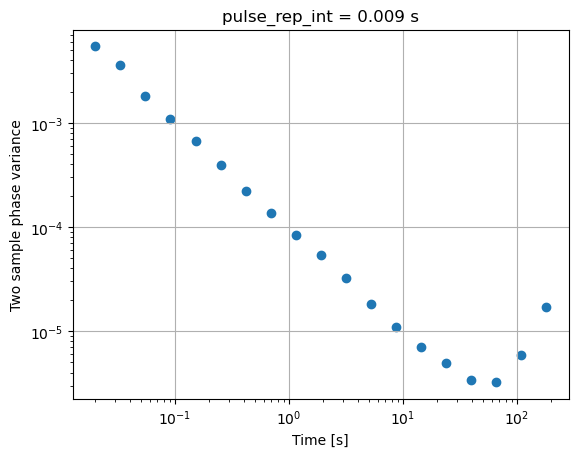

In [16]:
fig, ax = plt.subplots()
ax.loglog()
ax.scatter(ts, var)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Two sample phase variance')
ax.set_title(f"pulse_rep_int = {raw.attrs['config']['CHIRP']['pulse_rep_int']} s")
plt.grid()
fig.savefig(output_base_2svar + ".png")

In [ ]:
output_base_phase = os.path.join("20230628-outputs/", raw.attrs["basename"]+"-phase")

peak_idx_plot = peak_idxs.hvplot.scatter(x='pulse_idx')
peak_phase_plot = peak_phases.hvplot.scatter(x='pulse_idx', datashade=True)
peak_phase_rolling_plot = peak_phases.rolling(pulse_idx=100).mean().hvplot.scatter(x='pulse_idx', datashade=True)

2023-06-29 10:43:00,342 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.69 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:43:08,054 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-06-29 10:43:10,399 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 13.68 GiB -- Worker memory limit: 18.63 GiB
2023-06-29 10:43:16,339 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-06-29 10:43:20,470 - dist

In [ ]:
hv.save(peak_idx_plot, output_base_phase+"-peak-idx.png", fmt='png')
hv.save(peak_phase_plot, output_base_phase+"-peak-phase.png", fmt='png')
hv.save(peak_phase_rolling_plot, output_base_phase+"-peak-phase-rolling.png", fmt='png')

hv.save(peak_idx_plot, output_base_phase+"-peak-idx.html", fmt='widgets')
hv.save(peak_phase_plot, output_base_phase+"-peak-phase.html", fmt='widgets')
hv.save(peak_phase_rolling_plot, output_base_phase+"-peak-phase-rolling.html", fmt='widgets')

peak_idx_plot, peak_phase_plot, peak_phase_rolling_plot